In [1]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split,Dataset
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
#from pyimagesearch import config
import numpy as np
import argparse
import cv2
import os
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score
from torchvision.models import *
import random

In [2]:
os.getcwd()

'C:\\Users\\vanek\\Documents\\учеба\\4 семестр\\machine learning\\Курсовая'

In [3]:
os.chdir('данные')
os.getcwd()

'C:\\Users\\vanek\\Documents\\учеба\\4 семестр\\machine learning\\Курсовая\\данные'

In [4]:
class car_damage(Dataset):
    def __init__(self,excel_file,root_dir,transform = None):
        self.annotations = pd.read_excel(excel_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)#?
        y_label = torch.tensor(int(self.annotations.iloc[index,1]))#тут у нас значения [0,1]
        
        if self.transform:
            #image = self.transform(image)
            #image = np.expand_dims(np.transpose(self.transform(image),(1,2,0)),0)
            #image = np.transpose(self.transform(image),(1,2,0))#решил читать через cv2, поэтому тут значения поменялись
            image = self.transform(image)
        return (image,y_label)

In [5]:
DataSet = car_damage(excel_file = 'dat1.xlsx', root_dir = 'images', transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((254, 254)),#уменьшаю разрешение
    transforms.ToTensor(),#привожу к тензору
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),#нормализую данные
    ]))

In [6]:
#transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((300, 300)),
#     transforms.CenterCrop((100, 100)),
#     transforms.RandomCrop((80, 80)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=(-90, 90)),
#     transforms.RandomVerticalFlip(p=0.5),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#     ])

In [7]:
#plt.imshow(DataSet[4][0][0])

In [8]:
train_set,test_set = torch.utils.data.random_split(DataSet, [round(len(DataSet)*0.8), len(DataSet) - round(len(DataSet)*0.8)]) # разбиваю на обучающую и тестовую выборку

In [9]:
train_loader = DataLoader(dataset = train_set, batch_size = 16, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = 16, shuffle = True)

In [10]:
criterion = nn.CrossEntropyLoss() #вычисляет "перекрестную" потерю

In [11]:
from torchvision.models import *

**Строю график по даннным**

In [35]:
def plot(train_losses,test_losses,spec,fpr,acc,f1):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(spec, label='Specifity')
    plt.plot(fpr, label='False_Positive_Rate')
    plt.xlabel('Epoch')
    plt.ylabel('%')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(acc, label='Accuracy')
    plt.plot(f1, label='F1_rate')
    plt.xlabel('Epoch')
    plt.ylabel('')
    plt.legend()
    plt.show()

**Выбор оптимизатора**

In [13]:
def optimiz(opt, model, l = 0.001, momentum = 0.9):
    if opt  == 'Adam':
        return optim.Adam(model.parameters(), lr=0.001)
    if opt == 'SGD':
        return optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

**Процесс обученрия**

In [14]:
train_all = []
def func(model, opt, num_epochs = 5, l = 0.001,momentum = 0.9, flag = True):
    train = []
    train_losses = []
    test_losses = []
    spec = []
    acc = []
    fpr = []
    f1 = []
    
    optimizer = optimiz(opt,model,l,momentum) #выбор оптимизатора
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #выбираю на чем будет обучаться модель
    model.to(device)
    criterion.to(device)
    
    for epoch in range(num_epochs):
        train_loss = 0.0
        test_loss = 0.0
        running_loss = 0.0
        model.train()
        for images, labels in tqdm(train_loader):
            optimizer.zero_grad() #очищаю градиенты

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)#прямой проход
            loss = criterion(outputs, labels)

            loss.backward()#обратный проход
            optimizer.step()

            train_loss += loss.item()#суммирую ошибки
        
        correct = 0
        total = 0
        specificity = 0
        false_pr = 0
        f1_s = 0

        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                f1_s += f1_score(predicted, labels,average='weighted')
                if len(labels)!=1:
                    tn, fp, fn, tp = confusion_matrix(labels, predicted).ravel()
                else:
                    if (labels==1):
                        if labels == predicted:
                            tp = 1
                            fp = 0
                            fn = 0
                            tn = 0
                        else: 
                            tp = 0
                            fp = 1
                            fn = 0
                            tn = 0
                    else:
                        if labels == predicted:
                            tp = 0
                            fp = 0
                            fn = 0
                            tn = 1
                        else: 
                            tp = 0
                            fp = 0
                            fn = 1
                            tn = 0
                if tn !=0 or fp !=0:
                    specificity += tn / (tn+fp)
                    false_pr +=  fp/ (tn+fp)
        train_losses.append(train_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        spec.append(specificity/len(test_loader))
        accuracy = correct / total
        acc.append(accuracy)
        fpr.append(false_pr/len(test_loader))
        f1.append(f1_s/len(test_loader))


        # Выводим потери и точность
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f},\
    Test Accuracy: {acc[-1]:.4f}, Specifity: {spec[-1]:.4f}, FRP: {fpr[-1]:.4f}, f1_test: {f1[-1]:.4f}')
    
    if flag == True:
        plot(train_losses,test_losses,spec,fpr,acc,f1)
        num_images = 4
        fig, axs = plt.subplots(1, num_images, figsize=(20, 5))
            for i in range(num_images):

        idx = random.randint(0, len(images) - 1)
        image = images[idx].squeeze().cpu().numpy()
        axs[i].imshow(image.transpose(1, 2, 0))
        axs[i].set_title('Predicted: {}'.format(predicted[idx]))
        axs[i].axis('off')
    return [epoch+1, train_losses[-1],test_losses[-1],acc[-1],spec[-1],fpr[-1],f1[-1]]
    

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:18<00:00,  1.52s/it]


Epoch 1/5, Training Loss: 0.6641, Test Loss: 0.6013,    Test Accuracy: 0.6891, Specifity: 0.4317, FRP: 0.5491, f1_test: 0.7081


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:10<00:00,  1.36s/it]


Epoch 2/5, Training Loss: 0.6040, Test Loss: 0.6406,    Test Accuracy: 0.6512, Specifity: 0.6635, FRP: 0.3172, f1_test: 0.6544


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:21<00:00,  1.57s/it]


Epoch 3/5, Training Loss: 0.5657, Test Loss: 0.7036,    Test Accuracy: 0.6340, Specifity: 0.6784, FRP: 0.3024, f1_test: 0.6172


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:26<00:00,  1.66s/it]


Epoch 4/5, Training Loss: 0.5535, Test Loss: 0.6310,    Test Accuracy: 0.6524, Specifity: 0.8068, FRP: 0.1740, f1_test: 0.6566


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:15<00:00,  1.44s/it]


Epoch 5/5, Training Loss: 0.5327, Test Loss: 0.6139,    Test Accuracy: 0.6879, Specifity: 0.4722, FRP: 0.5085, f1_test: 0.6839


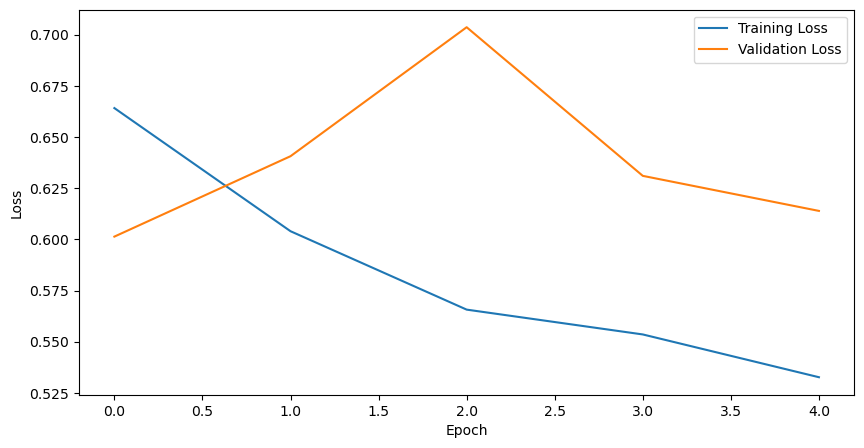

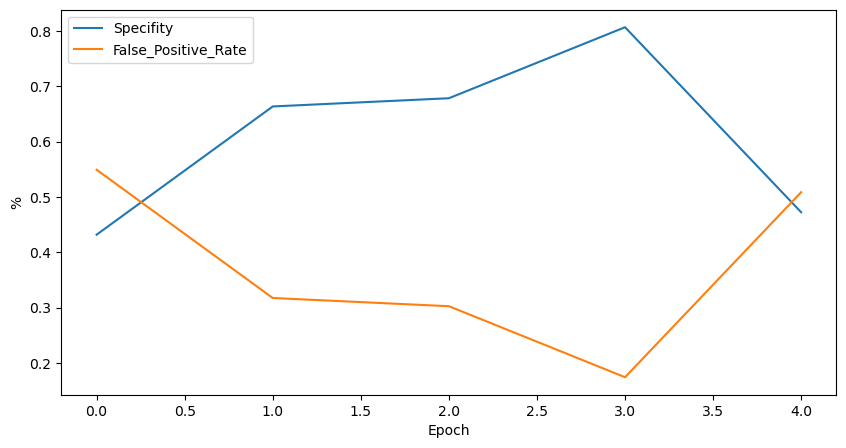

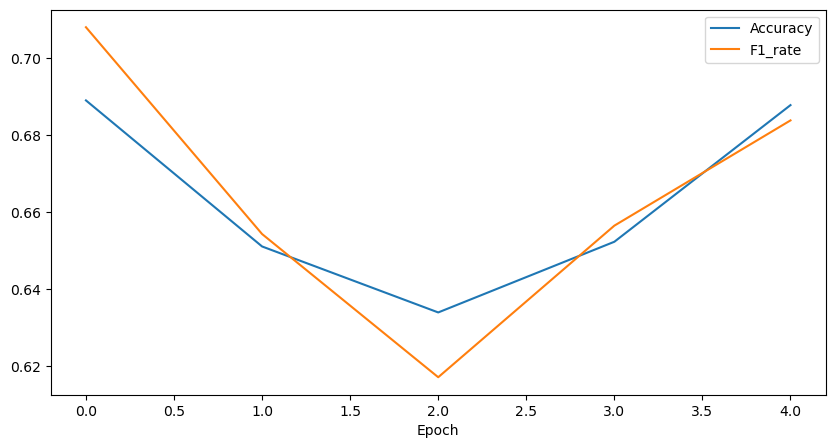

In [18]:
model = resnet18(weights = 'ResNet18_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 2)
train_all.append(func(model,'Adam'))

Со второй эпохи обучения resnet18 точность начинает резко падать, поэтому я решаю использовать другой оптимизатор

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:06<00:00,  1.27s/it]


Epoch 1/5, Training Loss: 0.6196, Test Loss: 0.5605,    Test Accuracy: 0.7234, Specifity: 0.5855, FRP: 0.4145, f1_test: 0.7334


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:05<00:00,  1.25s/it]


Epoch 2/5, Training Loss: 0.4514, Test Loss: 0.5908,    Test Accuracy: 0.7099, Specifity: 0.6723, FRP: 0.3084, f1_test: 0.7133


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:06<00:00,  1.28s/it]


Epoch 3/5, Training Loss: 0.2558, Test Loss: 0.6933,    Test Accuracy: 0.7050, Specifity: 0.5808, FRP: 0.4192, f1_test: 0.7129


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:05<00:00,  1.25s/it]


Epoch 4/5, Training Loss: 0.1066, Test Loss: 0.7882,    Test Accuracy: 0.7307, Specifity: 0.6759, FRP: 0.3048, f1_test: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [01:05<00:00,  1.25s/it]


Epoch 5/5, Training Loss: 0.0653, Test Loss: 0.9086,    Test Accuracy: 0.7307, Specifity: 0.6585, FRP: 0.3223, f1_test: 0.7359


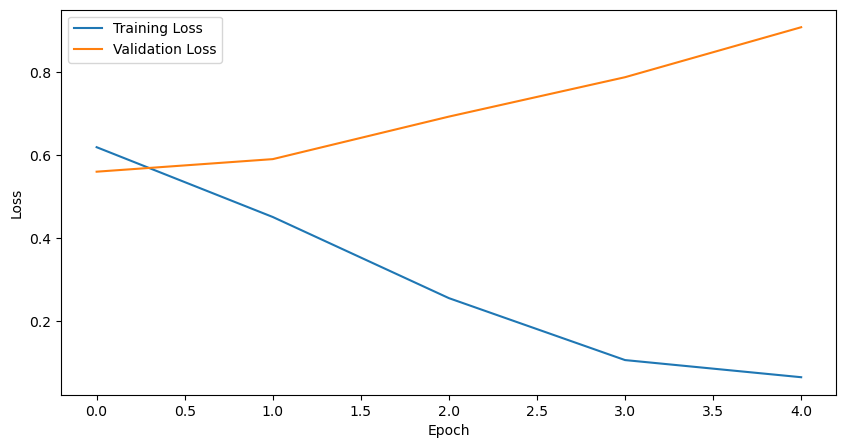

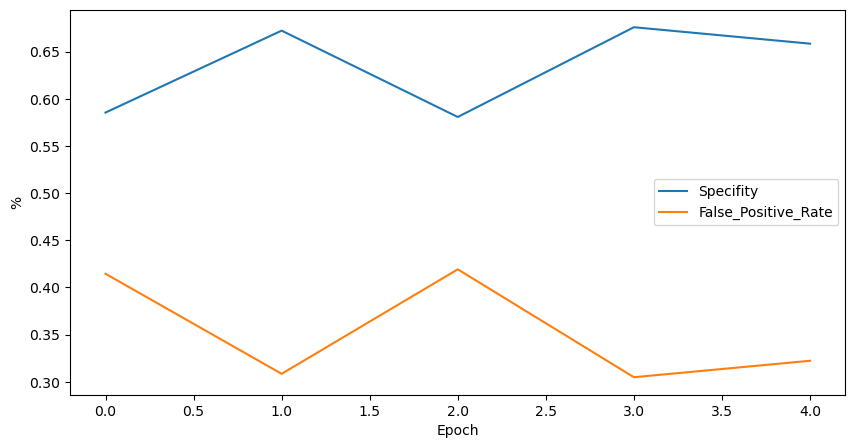

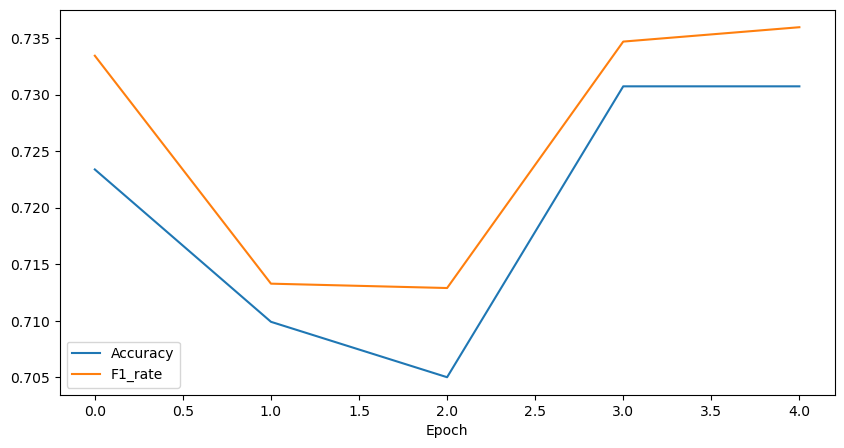

In [19]:
model = resnet18(weights = 'ResNet18_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 2)
train_all.append(func(model,'SGD'))

обученная модель resnet18 с оптимизатором SGD показывает результаты, намного превосходящие resnet18 с оптимизатором Adam, это видно по высокой точность и F1_rate

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:40<00:00,  3.08s/it]


Epoch 1/5, Training Loss: 0.5859, Test Loss: 0.5437,    Test Accuracy: 0.7258, Specifity: 0.7155, FRP: 0.2653, f1_test: 0.7095


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:33<00:00,  2.95s/it]


Epoch 2/5, Training Loss: 0.4134, Test Loss: 0.5322,    Test Accuracy: 0.7344, Specifity: 0.6011, FRP: 0.3989, f1_test: 0.7433


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:33<00:00,  2.96s/it]


Epoch 3/5, Training Loss: 0.1758, Test Loss: 0.7225,    Test Accuracy: 0.7234, Specifity: 0.5209, FRP: 0.4599, f1_test: 0.7371


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:33<00:00,  2.94s/it]


Epoch 4/5, Training Loss: 0.0846, Test Loss: 1.1224,    Test Accuracy: 0.6940, Specifity: 0.8782, FRP: 0.1025, f1_test: 0.7036


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:32<00:00,  2.93s/it]


Epoch 5/5, Training Loss: 0.0652, Test Loss: 0.8741,    Test Accuracy: 0.7540, Specifity: 0.7152, FRP: 0.2656, f1_test: 0.7599


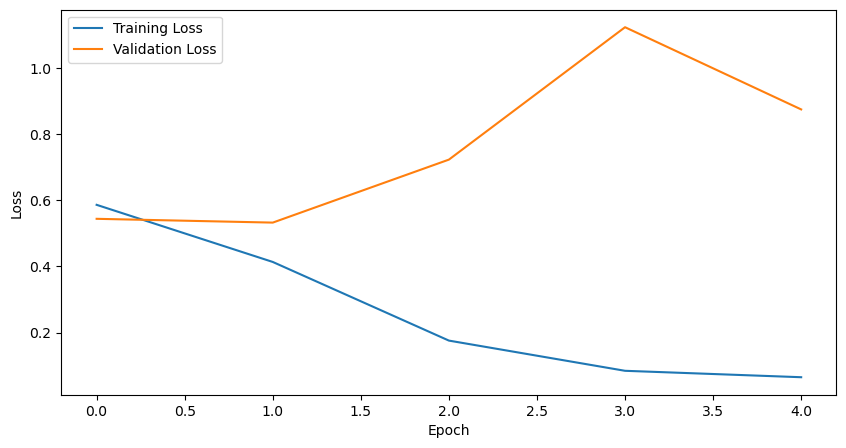

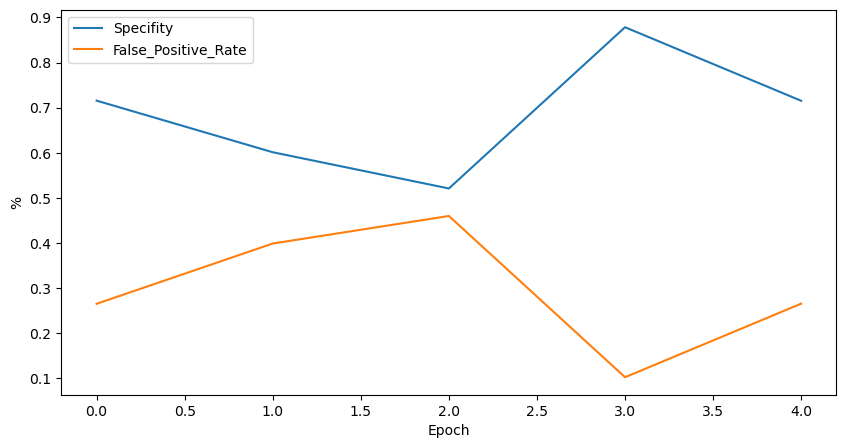

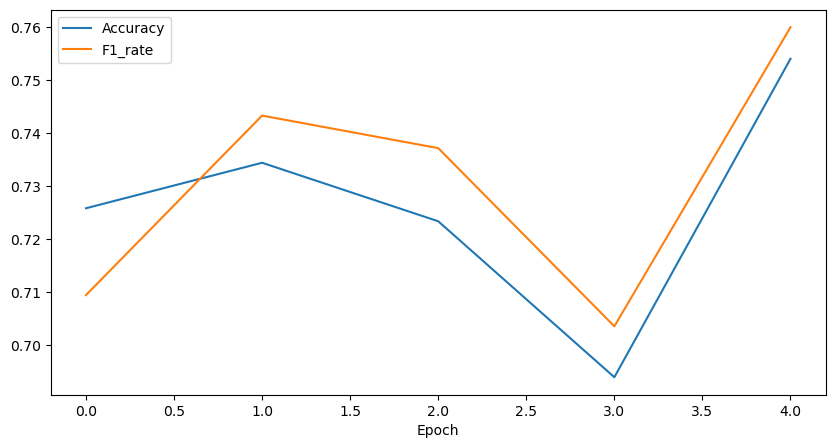

In [20]:
model = resnet50(weights = 'ResNet50_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 2)
train_all.append(func(model,'SGD'))

resnet50 с оптимизатором SGD показывается лучшие результаты, имея, наибольшую точность и F1 оценку, а также на первом графике можно увидеть, что данные не переобучены на тестовой выборке

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:48<00:00,  3.25s/it]


Epoch 1/5, Training Loss: 0.9355, Test Loss: 0.7391,    Test Accuracy: 0.6401, Specifity: 0.8473, FRP: 0.1334, f1_test: 0.6531


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:47<00:00,  3.22s/it]


Epoch 2/5, Training Loss: 0.3621, Test Loss: 0.6272,    Test Accuracy: 0.7136, Specifity: 0.6924, FRP: 0.3076, f1_test: 0.7140


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:47<00:00,  3.23s/it]


Epoch 3/5, Training Loss: 0.1645, Test Loss: 0.7156,    Test Accuracy: 0.7283, Specifity: 0.6060, FRP: 0.3748, f1_test: 0.7331


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:47<00:00,  3.22s/it]


Epoch 4/5, Training Loss: 0.0827, Test Loss: 0.7830,    Test Accuracy: 0.7356, Specifity: 0.5907, FRP: 0.3901, f1_test: 0.7441


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [02:43<00:00,  3.15s/it]


Epoch 5/5, Training Loss: 0.0690, Test Loss: 0.8317,    Test Accuracy: 0.7344, Specifity: 0.5853, FRP: 0.3955, f1_test: 0.7222


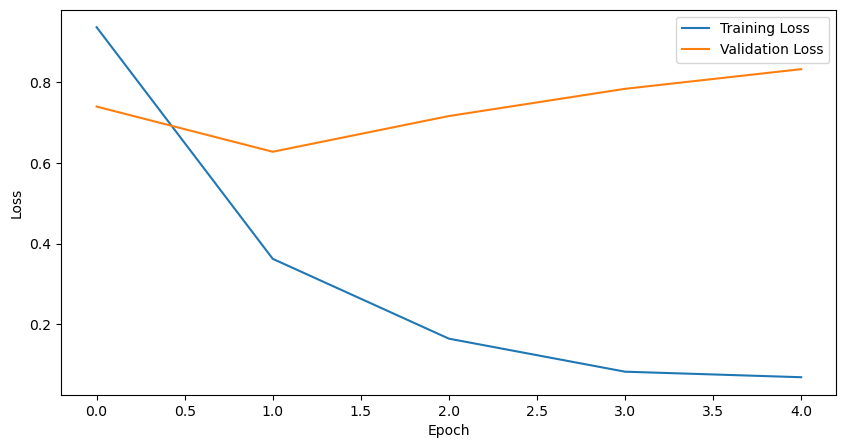

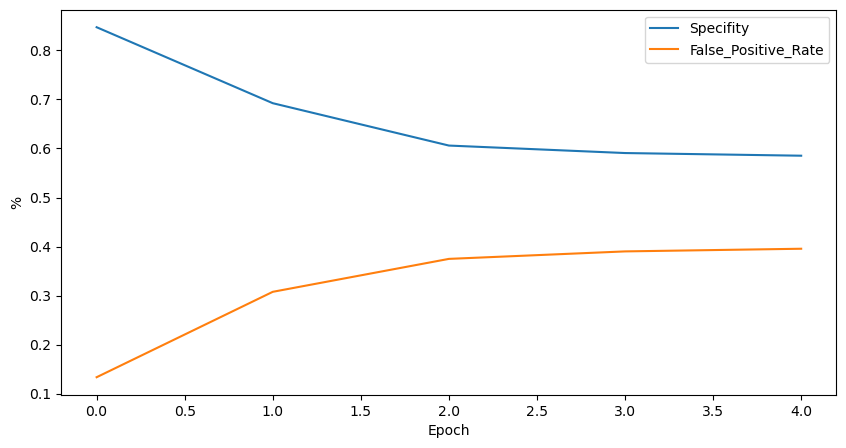

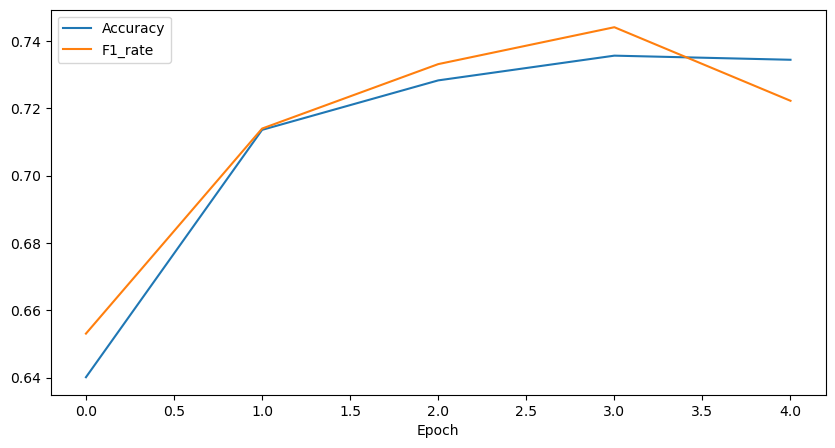

In [21]:
model = densenet121(weights = 'DenseNet121_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(model.classifier.in_features, 2)
train_all.append(func(model,'SGD'))

Densenet121 показала высокую точность и F1 оценку, а также Specifity и FPR стремящяеся к 0.5 говорит нам о том, что данные не переобучились и модель одинакого хорошо работает на всех картинках

In [28]:
pd.DataFrame(train_all,columns = ['epoch','train_loss','test_loss','accuracy','Specifity','FRP','F1_test'], index = ['resnet18 imagenet ADAM','resnet18 imagenet SGD','resnet50 imagenet SGD','densenet121 imagenet SGD'])

,epoch,train_loss,test_loss,accuracy,Specifity,FRP,F1_test
resnet18 imagenet ADAM,5,0.532650,0.613871,0.687882,0.472233,0.508537,0.683911
resnet18 imagenet SGD,5,0.065295,0.908624,0.730722,0.658508,0.322261,0.735945
resnet50 imagenet SGD,5,0.065162,0.874123,0.753978,0.715175,0.265594,0.759922
densenet121 imagenet SGD,5,0.069007,0.831666,0.734394,0.585264,0.395505,0.722217


Отчет:

Resnet50 - модель, показавшая наилучшие результаты из всех моделей, высокая точность и f1 оценка говорит нам о точности прогнозов модели, но несмотря на это, resnet18 - модель с неплохой точностью и f1 оценкой показало скорость обучения, более чем в 3 раза быстрее, чем обучения на остальных моделей, а модель densenet121 одинаково хорошо описывает все данные